 # Utilisation du jeux de données 2 (normal/anormal) avec un modèle SVM

Methode:
- j'entraine un modèle SVM sur le dataset 1 (base d'attributs attributs)
- je prédis sur le dataset anormal
- j'utilise la classification du dataset 2 pour reentrainer le modèle de départ

In [1]:
import os
import sys
sys.path.append('../src')

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time


## datasets <a class="anchor" id="datasets"></a>

calcul des features sur ces bases

In [2]:
if not os.path.isfile('../data/processed/mitbih_train_smote_perturb_13000.csv'):
    Xo,yo = load_balanced.load_balanced_data(method='smote-perturb',n_normal=25000,
                       smote_perturb_smote_ratio=0.5)
    pd.DataFrame(np.concatenate((Xo,np.expand_dims(yo,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_13000.csv',index=None,header=None)
if not os.path.isfile('../data/processed/features_mitbih_train_smote_perturb_13000.csv'):
    from features import build_features
    build_features.transform_inputs(files=['../data/processed/mitbih_train_smote_perturb_50000.csv'],
                     outdir = '../data/processed',
                    applyfilter='gaussian',
                      paramfilter=1,
                      Fs=125,
                      nech=6)
for file in ['../data/processed/features_mitbih_train_under.csv',
             '../data/processed/features_ptbdb_abnormal.csv',
             '../data/processed/features_ptbdb_normal.csv']:
    if not os.path.isfile(file):
        from features import build_features
        build_features.transform_inputs(files=[file],
                         outdir = '../data/processed',
                         applyfilter='gaussian',
                          paramfilter=1,
                          Fs=125,
                          nech=6)


## SVM sur features <a class="anchor" id="svm_features"></a>

In [3]:
from sklearn import preprocessing ,svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns


In [4]:
def svc_modeling(datafile,outmodelfile,class_weight=None):
    # Get the start time
    start_time = time.time()
    df = pd.read_csv(datafile)
    y_train = df.pop('target')
    X_train = df
    clf,scaler = _svc_modeling(X_train,y_train,outmodelfile,class_weight=class_weight)
  
    return clf,scaler

def _svc_modeling(X_train,y_train,outmodelfile,class_weight=None):
    # Get the start time
    start_time = time.time()
   
    df = pd.read_csv('../data/processed/features_mitbih_test.csv')
    y_test = df.pop('target')
    X_test = df

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled  = scaler.transform(X_train )
    X_test_scaled  = scaler.transform(X_test )

    clf = SVC(gamma=0.1,C=1,kernel='rbf', probability=True,max_iter=1000,class_weight=class_weight)
    clf.fit(X_train_scaled,y_train)

    y_pred = clf.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

    print(pd.crosstab(y_test,y_pred,colnames=['prediction']))

    with open(outmodelfile,'wb') as f:
        pickle.dump(clf,f)
    # Get the end time
    end_time = time.time()
    
    # Calculate the execution time
    elapsed_time = end_time - start_time
    print(f'Execution time: {elapsed_time} seconds')
    
    return clf,scaler

### Base sous echantillonée avec les paramètres du gridsearch obtenus sur le sous echantillonage


In [4]:
svc_modeling('../data/processed/features_mitbih_train_under.csv','../models/svm_features_undersampled.pkl')

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     18118
         1.0       0.30      0.76      0.43       556
         2.0       0.52      0.94      0.67      1448
         3.0       0.17      0.91      0.28       162
         4.0       0.98      0.93      0.95      1608

    accuracy                           0.86     21892
   macro avg       0.59      0.88      0.65     21892
weighted avg       0.94      0.86      0.88     21892

prediction    0.0  1.0   2.0  3.0   4.0
target                                 
0.0         15339  965  1105  677    32
1.0            73  422    49   10     2
2.0            29    6  1366   44     3
3.0             3    4     8  147     0
4.0            28    6    77    1  1496


### Base sur echantillonée avec les paramètres du gridsearch obtenus sur le sous echantillonage (sinon c'est long )<a class="anchor" id="svm_features_sur"></a>


In [10]:
clf,scaler = svc_modeling('../data/processed/features_mitbih_train_smote_perturb_13000.csv','..\models\svm_features_13000.pkl')

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     18118
         1.0       0.54      0.85      0.66       556
         2.0       0.83      0.96      0.89      1448
         3.0       0.55      0.88      0.67       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.78      0.93      0.84     21892
weighted avg       0.97      0.96      0.96     21892

prediction    0.0  1.0   2.0  3.0   4.0
target                                 
0.0         17378  389   226   92    33
1.0            63  472    18    2     1
2.0            19    5  1395   25     4
3.0             8    1    10  143     0
4.0             7    5    27    0  1569


In [11]:
clfw,scaler = svc_modeling('../data/processed/features_mitbih_train_smote_perturb_13000.csv','..\models\svm_features_13000_weigth.pkl',class_weight={0:1,1:2/3,2:1,3:1/3,4:1})

C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     18118
         1.0       0.86      0.33      0.48       556
         2.0       0.83      0.97      0.90      1448
         3.0       0.83      0.65      0.73       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.90      0.78      0.81     21892
weighted avg       0.96      0.96      0.96     21892

prediction    0.0  1.0   2.0  3.0   4.0
target                                 
0.0         17844   30   205    4    35
1.0           351  183    20    1     1
2.0            28    0  1400   16     4
3.0            28    0    29  105     0
4.0            16    0    23    0  1569
Execution time: 362.2965211868286 seconds


Bien que des normaux soient mal classés, les anormaux sont bien classés

### Base sur echantillonée 50000 signaux

In [5]:

clf,scaler = svc_modeling('../data/processed/features_mitbih_train_smote_perturb_50000.csv','..\models\svm_features_50000.pkl')


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     18118
         1.0       0.53      0.42      0.47       556
         2.0       0.93      0.95      0.94      1448
         3.0       0.60      0.90      0.72       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.84      0.82     21892
weighted avg       0.96      0.96      0.96     21892

prediction    0.0  1.0   2.0  3.0   4.0
target                                 
0.0         17762  202    69   61    24
1.0           310  231    10    3     2
2.0            36    0  1376   32     4
3.0             7    1     9  145     0
4.0            18    0    10    1  1579
Execution time: 1958.5423045158386 seconds


## deuxieme dataset

In [14]:
df = pd.read_csv('../data/processed/features_mitbih_train_smote_perturb_50000.csv')
y_train = df.pop('target')
X_train = df
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled  = scaler.transform(X_train )

on charge les anormaux du deuxième dataset et on regarde comment c'est prédit

In [15]:
df = pd.read_csv('../data/processed/features_ptbdb_abnormal.csv')
y2 = df.pop('target')
X2 = df
# charge aussi les signaux associées
S2,_ = load_balanced.load('../data/raw/ptbdb_abnormal.csv')
X2_scaled  = scaler.transform(X2 )


In [16]:
clf = pickle.load(open('..\models\svm_features_50000.pkl', 'rb'))

Predit les anormaux du deuxième dataset

In [17]:
y2 = clf.predict(X2_scaled)

Nombre de signaux par classe


In [18]:

pd.Series(y2).value_counts()

0.0    9004
2.0     829
4.0     363
1.0     279
3.0      31
Name: count, dtype: int64

Manifestement cela ne marche pas bien car l'on ne devriat pas avoir de classe 0. bon on essaie quand même de rajouter à l'entrainement l'ensembles des prédictions anormales

In [19]:
y2p = clf.predict_proba(X2_scaled)

In [20]:
C2_i = [np.array([k for k,x in enumerate(y2) if x==i]) for i in range(5)]

Text(0.5, 1.0, 'distribution des probas pour chaque classe')

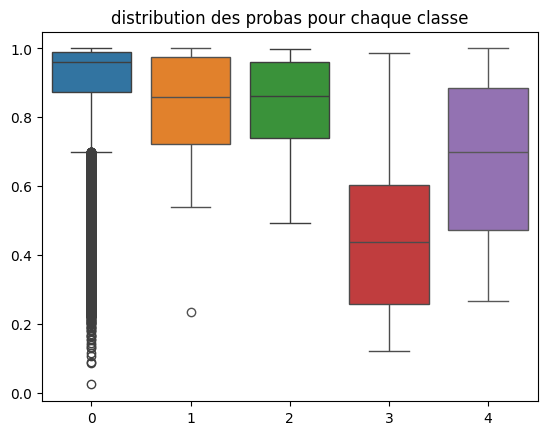

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
for k in range(5):
    sns.boxplot(x=k,y=y2p[y2==k,k],ax=ax)
ax.set_title('distribution des probas pour chaque classe')

malheureusement, quand il dit que c'est classe 0, il a plutot une très bonne proba

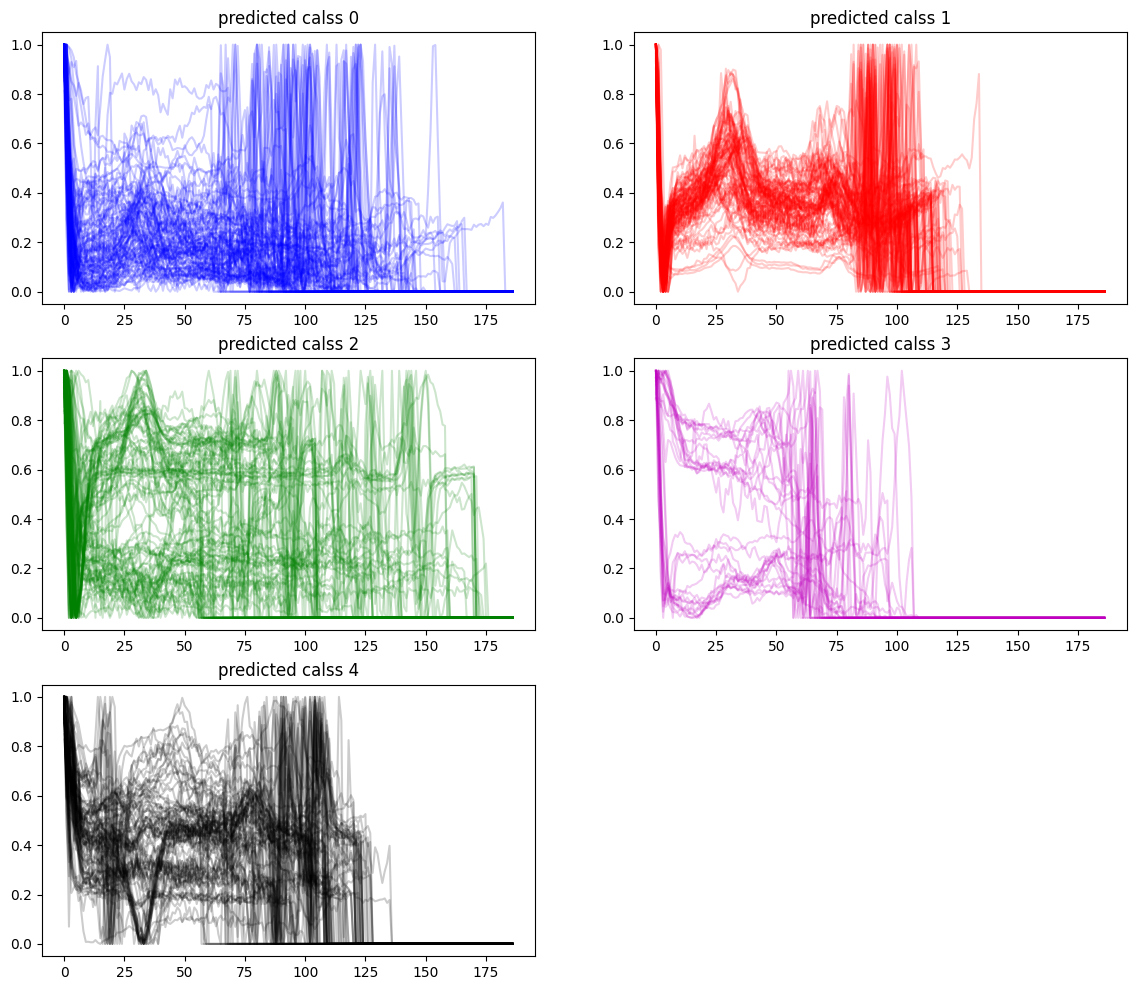

In [22]:
fig = plt.figure(figsize=(14,12))
colors = ['b','r','g','m','k']
for c in range(5):
    ax = fig.add_subplot(321+c)
    list_ii = C2_i[c][0:100]
    for kii,ii in enumerate(list_ii):
        ax.plot(S2[ii,:],color=colors[c],alpha=0.2)
    ax.set_title('predicted calss %d' %c)


In [31]:
X2

,R,R_width,R_height,R_prominence,P1,P1_width,P1_height,P1_prominence,P2,P2_width,...,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,DN_Mean,DN_Spread_Std
0,0.480,0.241382,0.788879,0.788879,0.144,0.028652,0.927393,0.282036,0.352,0.011768,...,0.326203,0.926310,5.0,0.711360,0.804878,0.731707,0.024544,0.379718,0.211966,0.324973
1,0.952,0.019632,0.950767,0.950767,0.256,0.088894,0.377004,0.249193,0.816,0.042105,...,0.727273,0.734629,6.0,1.770644,0.146341,0.853659,0.269981,0.612455,0.129408,0.139587
2,0.704,0.071095,0.592166,0.592166,0.448,0.107668,0.582092,0.070334,0.624,0.019238,...,0.481283,0.939523,6.0,1.255544,0.853659,0.804878,0.024544,0.303758,0.278847,0.300592
3,0.800,0.014329,1.000000,0.767098,0.144,0.104900,0.415043,0.041935,0.648,0.066804,...,0.545455,0.811551,7.0,1.318281,0.853659,0.853659,0.024544,0.491804,0.194604,0.202419
4,0.000,0.000000,0.000000,0.000000,0.168,0.011235,0.290387,0.007776,0.368,0.099998,...,0.299465,0.900343,12.0,0.698770,0.146341,0.731707,0.073631,0.278057,0.079581,0.167693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.904,0.025710,0.796568,0.761530,0.264,0.098041,0.402051,0.149593,0.704,0.051909,...,0.556150,0.769462,14.0,1.383338,0.170732,0.634146,0.171806,0.560250,0.139221,0.167215
10502,0.640,0.130878,0.805444,0.805444,0.280,0.050237,0.562719,0.154831,0.416,0.021472,...,0.427807,0.891337,9.0,1.170158,0.829268,0.780488,0.024544,0.433799,0.211359,0.265909
10503,1.064,0.050574,0.969245,0.969245,0.320,0.155232,0.168546,0.042510,0.800,0.062037,...,0.727273,0.862141,7.0,1.592861,0.195122,0.731707,0.196350,0.496959,0.143956,0.170729
10504,0.816,0.042853,0.931595,0.931595,0.328,0.403954,0.304611,0.106289,0.640,0.036615,...,0.636364,0.871953,12.0,1.392502,0.146341,0.731707,0.122718,0.444040,0.186969,0.185043


In [38]:
X3 = pd.concat((X_train,
                     X2.loc[C2_i[1],:],
                     X2.loc[C2_i[2],:],
                     X2.loc[C2_i[3],:],
                     X2.loc[C2_i[4],:]))
y3 = pd.concat((y_train,
                pd.Series(y2[C2_i[1]]),
                 pd.Series(y2[C2_i[2]]),
                 pd.Series(y2[C2_i[3]]),
                 pd.Series(y2[C2_i[4]])))

In [39]:
clf_d2,scaler_d2 = _svc_modeling(X3,y3,'..\models\svm_features_50000_joinedd2.pkl',class_weight=None)

C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     18118
         1.0       0.29      0.53      0.37       556
         2.0       0.93      0.95      0.94      1448
         3.0       0.58      0.87      0.70       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.94     21892
   macro avg       0.75      0.86      0.79     21892
weighted avg       0.96      0.94      0.95     21892

prediction    0.0  1.0   2.0  3.0   4.0
target                                 
0.0         17231  729    68   70    20
1.0           244  295    11    3     3
2.0            44    2  1370   28     4
3.0             9    1    11  141     0
4.0            20    1    10    1  1576
Execution time: 1515.3211777210236 seconds


c'est pire cela n'a pas marché du tout

## Conclusion

cette piste ne semble pas fonctionner. même si dans cette étude il y a des choses à améliorer, par exemple, refaire le gridsearch, oversampler les nouveaux, ne prendre que les meilleurs probas, dès le début, les résultats ne poussent pas à poursuivre.
Cependant, je vais me concentrer sur un modèle CNN et le faire en deux fois:
* prédire normal et anormal
* predire ensuite le type d'anomalie